In [1]:
import pandas as pd

data = pd.read_csv('dataset.csv', index_col='date')
data.index.freq = '1min'
data.index = pd.DatetimeIndex(data.index).to_period('1min')

co2_data = data['CO2']

split_point = int(0.7 * len(co2_data))
train, test = co2_data[:split_point], co2_data[split_point:]


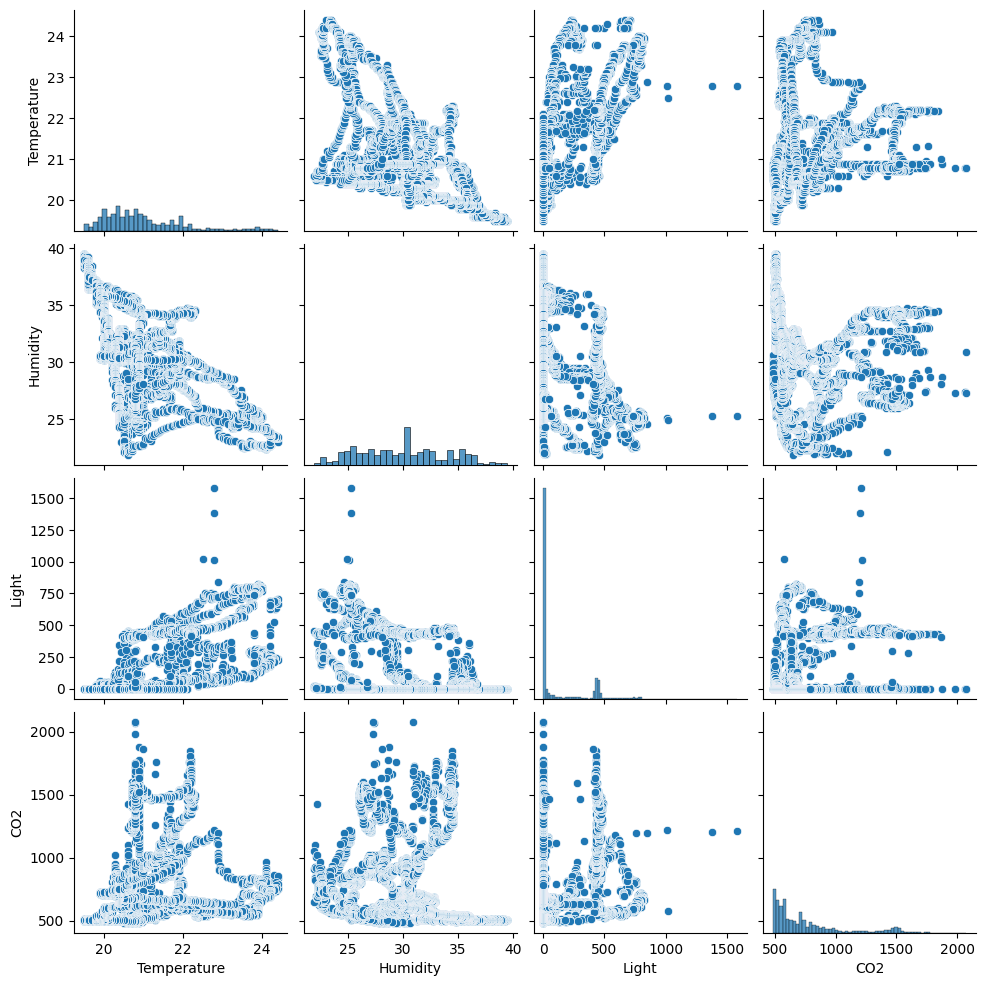

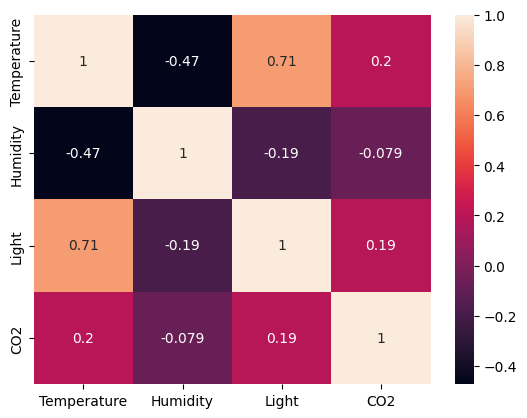

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatterplots
sns.pairplot(data)
plt.show()

# Correlation Matrix
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()


In [3]:
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

# Check for stationarity in the CO2 data
adf_result = adfuller(train)
adf_result

# Finding best ARIMA parameters
auto_model = auto_arima(train, seasonal=False, trace=True)  # error_action='ignore', suppress_warnings=True
auto_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=59233.687, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60029.820, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=59997.355, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=59979.849, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=60027.837, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=59312.969, Time=0.98 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=59244.234, Time=0.78 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=59234.998, Time=2.64 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=59235.078, Time=1.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=59656.767, Time=0.54 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=59262.631, Time=1.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=59234.899, Time=1.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=59237.204, Time=1.26 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=59231.767, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6826
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -29610.883
Date:                Mon, 11 Dec 2023   AIC                          59231.767
Time:                        00:12:55   BIC                          59265.909
Sample:                    02-11-2015   HQIC                         59243.547
                         - 02-16-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9575      0.008    124.925      0.000       0.943       0.973
ar.L2         -0.3979      0.007    -60.767      0.000      -0.411      -0.385
ma.L1         -0.9648      0.008   -116.149      0.000      -0.981      -0.949
ma.L2          0.1666      0.008     19.984      0.000       0.150       0.183
sigma2       343.5178      0.225   1524.480      0.000     343.076     343.959
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):         689791308.65
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            24.25
Prob(H) (two-sided):                  0.00   Kurtosis:                      1559.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [4]:
from statsmodels.tsa.arima.model import ARIMA

# Stepwise approach for prediction
forecast = []

for t in test:
    # Fit the model
    model = ARIMA(train, order=auto_model.order)
    model_fit = model.fit()
    
    # Forecast the next value
    forecast_value = model_fit.forecast(steps=1)
    forecast.append(forecast_value.iloc[0])

    # Update the train dataset with the actual observed value
    new_data = pd.Series([t], index=[test.index[len(forecast) - 1]])
    train = pd.concat([train, new_data])


/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.p

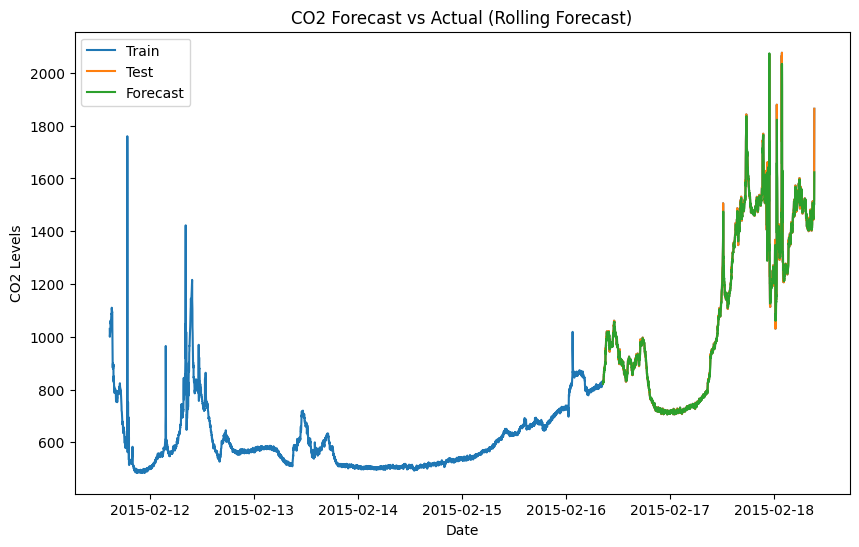

Mean Absolute Error (MAE): 9.35


In [12]:
import numpy as np

train.index = train.index.to_timestamp()
test.index = test.index.to_timestamp()

# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.title('CO2 Forecast vs Actual (Rolling Forecast)')
plt.xlabel('Date')
plt.ylabel('CO2 Levels')
plt.legend()
plt.show()

# Mean Absolute Error (MAE)
MAE = np.mean(abs(forecast - test))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))
